In [1]:
import pandas as pd
import numpy as np
from numpy import mean, std, median
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,  train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, recall_score,r2_score, accuracy_score, cohen_kappa_score, classification_report, confusion_matrix, precision_score,f1_score 
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, KFold, StratifiedKFold 
from imblearn.pipeline import Pipeline 
from imblearn.pipeline import make_pipeline as imbpipeline
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
#Random seed used in R was 7
random_seed=7

In [3]:
#read input data
#data=pd.read_csv('EX1_Input_MV.csv') #all 986 synsets
data=pd.read_csv('EX1_Input_AllAgreed.csv') #839 synsets where all annotators agree

In [4]:
d_tools=pd.DataFrame(data.loc[data['Domain']=='tool'])
d_fruit=pd.DataFrame(data.loc[data['Domain']=='fruit'])
d_music=pd.DataFrame(data.loc[data['Domain']=='music'])
d_furn=pd.DataFrame(data.loc[data['Domain']=='furn'])
d_garm=pd.DataFrame(data.loc[data['Domain']=='garm'])

In [5]:
#three domain gold standard for reproducing lauras results
#three=data[data['domain_x']!='furn']
#fmt=three[three['domain_x']!='garm']

In [8]:
#set features and target variable
features=[
   'ngrams_last_mean',
 'nrdirhypers',
 'nrhypos',
 'nrpartrels_normalised',
 'depthfromtopsynset_normalised',
 'glosslength_normalised',
 'minwordlength',
 'nroflemmas',
 'polyscore_max']
target=['vote']

In [9]:
#train on 2 domains test on one unseen to see performance across new domains
#only for reproducing lauras results
#music=[d_tools, d_fruit]
#fruit=[d_tools, d_music]
#tools=[d_fruit, d_music]
#m=pd.concat(music)
#f=pd.concat(fruit)
#t=pd.concat(tools)

In [10]:
#train on 4 domains test on one unseen 
garments=[d_furn, d_fruit, d_music, d_tools] #training set to test on garments..
furniture=[d_fruit, d_music, d_tools, d_garm]
fru=[d_furn, d_music, d_tools, d_garm]
mus=[d_furn, d_fruit, d_tools, d_garm]
too=[d_furn, d_fruit, d_music, d_garm]
g=pd.concat(garments)
furn=pd.concat(furniture)
fr=pd.concat(fru)
mu=pd.concat(mus)
to=pd.concat(too)

In [11]:
#set train as df with training data for test set 
#so furn is fruit, music tools and garments and d_furn is furniture
X_train=np.array(furn[features])
X_test=np.array(d_furn[features])
y_train=np.array(furn[target])
y_test=np.array(d_furn[target])

In [13]:
#run SMOTE algorithm to deal with class imbalances - make basic class same amount as non-basic
sm = SMOTE(random_state=random_seed, k_neighbors=2)
X_train, y_train = sm.fit_resample(X_train, y_train)
print ('Shape of oversampled data: {}'.format(X_train.shape))
print ('Shape of Y: {}'.format(y_train.shape))

Shape of oversampled data: (1002, 9)
Shape of Y: (1002,)


In [14]:
#define model and fit oversampled training sets
rf = RandomForestClassifier(random_state=random_seed, max_features="sqrt", n_estimators=500, oob_score=True, criterion='gini', bootstrap=True).fit(X_train, y_train.ravel())

In [15]:
kappa_scorer=make_scorer(cohen_kappa_score)

In [16]:
pipeline=imbpipeline(sm, rf)

In [17]:
#predict test set from training split
y_pred = pipeline.predict(X_test)
cr=(classification_report(y_test,y_pred, output_dict=True))
report=pd.DataFrame(cr).transpose()
report
cr=(classification_report(y_test,y_pred, output_dict=True))
ck=(cohen_kappa_score(y_test, y_pred))
ba=(balanced_accuracy_score(y_test, y_pred))
report=pd.DataFrame(cr).transpose()
report['Cohen Kappa']=ck
report['Balanced Accuracy']=ba

In [18]:
report['Trained on']='fruit tools music garments'
report['Tested on']='furn'

In [19]:
report

,precision,recall,f1-score,support,Cohen Kappa,Balanced Accuracy,Trained on,Tested on
b,0.333333,0.900000,0.486486,20.00000,0.389035,0.839571,fruit tools music garments,furn
nb,0.984496,0.779141,0.869863,163.00000,0.389035,0.839571,fruit tools music garments,furn
accuracy,0.792350,0.792350,0.792350,0.79235,0.389035,0.839571,fruit tools music garments,furn
macro avg,0.658915,0.839571,0.678175,183.00000,0.389035,0.839571,fruit tools music garments,furn
weighted avg,0.913331,0.792350,0.827964,183.00000,0.389035,0.839571,fruit tools music garments,furn


Feature: 0, Score: 0.14068
Feature: 1, Score: 0.07079
Feature: 2, Score: 0.07176
Feature: 3, Score: 0.07231
Feature: 4, Score: 0.36282
Feature: 5, Score: 0.11873
Feature: 6, Score: 0.07268
Feature: 7, Score: 0.03868
Feature: 8, Score: 0.05155


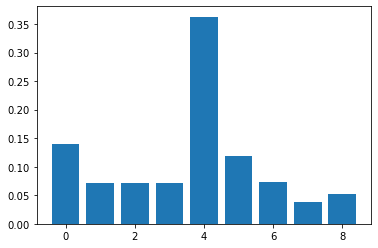

In [20]:
# get feature importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig1=plt.figure()
a=plt.bar([x for x in range(len(importance))], importance)
#plt.savefig('ck/feature_importance_global.png')
plt.show()

In [21]:
imp=[]
for i,v in enumerate(importance):
    imp.append(v)

In [22]:
df4=pd.DataFrame(imp)
df4['Features']=features
df4=df4.rename(columns={0:'Importance'})

In [23]:
df5=df4[['Features', 'Importance']].sort_values('Importance',ascending=False)

In [24]:
df5=df5.rename(columns={'index':'Rank'})

In [25]:
df5

,Features,Importance
4,depthfromtopsynset_normalised_x,0.362821
0,ngrams_last_mean,0.140681
5,glosslength_normalised_x,0.118729
6,minwordlength_x,0.072677
3,nrpartrels_normalised_x,0.072311
2,hypos_normalised,0.071763
1,dir_hypers_normalised,0.070789
8,polyscore_max_x,0.051548
7,nroflemmas_x,0.038681


In [26]:
#report.to_csv('results/CR_furn_unseen_benchmark.csv')

In [27]:
#df5.to_csv('results/FI_furn_unseen_benchmark.csv')